In [25]:
import pandas as pd
# 超参数
COLS_LOTTERY_NUMBER_1 = '号码1'
COLS_LOTTERY_NUMBER_2 = '号码2'
COLS_LOTTERY_NUMBER_3 = '号码3'
COLS_INDEX = '期号'
COLS_ALL = [COLS_INDEX, COLS_LOTTERY_NUMBER_1, COLS_LOTTERY_NUMBER_2, COLS_LOTTERY_NUMBER_3, '跨度','和值']

# 读取excel文件并获取指定列dataframe
df = pd.read_excel('../Data/福彩3D历史开奖.xlsx', usecols=COLS_ALL)
df = df[:100]
print(df)

         期号  号码1  号码2  号码3  跨度  和值
0   2024270    6    9    9   3  24
1   2024269    3    8    8   5  19
2   2024268    9    3    1   8  13
3   2024267    2    2    7   5  11
4   2024266    3    9    0   9  12
..      ...  ...  ...  ...  ..  ..
95  2024175    4    8    8   4  20
96  2024174    2    3    6   4  11
97  2024173    4    4    9   5  17
98  2024172    9    0    8   9  17
99  2024171    4    8    0   8  12

[100 rows x 6 columns]


In [26]:
### 添加所需要的列 ###
import utils
cols_lottery = [COLS_LOTTERY_NUMBER_1, COLS_LOTTERY_NUMBER_2, COLS_LOTTERY_NUMBER_3]

# 特征列：本期是否有某数字
df['本期是否有0'] = utils.check_number_in_lottery(df, cols_lottery, 0)
df['本期是否有1'] = utils.check_number_in_lottery(df, cols_lottery, 1)
df['本期是否有2'] = utils.check_number_in_lottery(df, cols_lottery, 2)
df['本期是否有3'] = utils.check_number_in_lottery(df, cols_lottery, 3)
df['本期是否有4'] = utils.check_number_in_lottery(df, cols_lottery, 4)
df['本期是否有5'] = utils.check_number_in_lottery(df, cols_lottery, 5)
df['本期是否有6'] = utils.check_number_in_lottery(df, cols_lottery, 6)
df['本期是否有7'] = utils.check_number_in_lottery(df, cols_lottery, 7)
df['本期是否有8'] = utils.check_number_in_lottery(df, cols_lottery, 8)
df['本期是否有9'] = utils.check_number_in_lottery(df, cols_lottery, 9)

# 特征列：奇偶
df['和值为偶数'] = utils.check_even_number(df, '和值')
df['跨度为偶数'] = utils.check_even_number(df, '跨度')
df['号码1为偶数'] = utils.check_even_number(df, COLS_LOTTERY_NUMBER_1)
df['号码2为偶数'] = utils.check_even_number(df, COLS_LOTTERY_NUMBER_2)
df['号码3为偶数'] = utils.check_even_number(df, COLS_LOTTERY_NUMBER_3)
df['本期全为偶数'] = utils.check_all_even_numbers(df, cols_lottery)
df['本期全为奇数'] = utils.check_all_odd_numbers(df, cols_lottery)

# 预测列
df['下期是否全为偶数'] = utils.predict_all_even_numbers(df, cols_lottery)
# df['下期百位是否有2'] = utils.check_number_in_next_column(df, COLS_LOTTERY_NUMBER_1, 3)
df = df.drop(df.index[0])    # 从df中删除第一行，因为这一行没办法确认下一期是否有指定数字
print(df.head(5))

        期号  号码1  号码2  号码3  跨度  和值  本期是否有0  本期是否有1  本期是否有2  本期是否有3  ...  \
1  2024269    3    8    8   5  19   False   False   False    True  ...   
2  2024268    9    3    1   8  13   False    True   False    True  ...   
3  2024267    2    2    7   5  11   False   False    True   False  ...   
4  2024266    3    9    0   9  12    True   False   False    True  ...   
5  2024265    2    4    5   3  11   False   False    True   False  ...   

   本期是否有8  本期是否有9  和值为偶数  跨度为偶数  号码1为偶数  号码2为偶数  号码3为偶数  本期全为偶数  本期全为奇数  \
1    True   False  False  False   False    True    True   False   False   
2   False    True  False   True   False   False   False   False    True   
3   False   False  False  False    True    True   False   False   False   
4   False    True   True  False   False   False    True   False   False   
5   False   False  False  False    True    True   False   False   False   

   下期是否全为偶数  
1     False  
2     False  
3     False  
4     False  
5     False  

[5 rows x 24 column

In [27]:
from sklearn.model_selection import train_test_split

COLS_Y = '下期是否全为偶数'
COLS_Y_CLASSNAME = ["不全为偶", "全为偶"]
CLASS_WEIGHTS = {0: 1, 1: 1}

## 取需要训练的值
cols_x = df.drop(columns=[COLS_Y,COLS_INDEX])
cols_y = df[COLS_Y]
# print(cols_x)
# print(cols_y)
cols_x_names = cols_x.columns.tolist()

Xtrain, Xtest, Ytrain, ytest = train_test_split(cols_x, cols_y, test_size = 0.002, random_state=102) 

print(Xtrain.shape)
print(Xtest.shape)

(98, 22)
(1, 22)


In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# 训练模型
clf = RandomForestClassifier(n_estimators=1000,  
                             max_depth = 3, 
                             criterion='entropy',
                             min_samples_leaf=10, 
                             class_weight=CLASS_WEIGHTS,
                             bootstrap=False,   # 特别核心，所有决策树都用全部数据做训练
                             random_state = 11)  #最大{max_depth}层，最少也需要{lefa}个样本才生成分支
clf = clf.fit(Xtrain, Ytrain) 

# 预测测试集
y_pred = clf.predict(Xtest)

# 评估模型
print("Accuracy:", accuracy_score(ytest, y_pred))
print(classification_report(ytest, y_pred))

#print('精准度： '+str(clf.score(Xtest, ytest))) #返回预测的准确度
#print([*zip(feature_name,clf.feature_importances_)]) #返回决策树各自变量的重要程度

Accuracy: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



In [29]:
### 找到那些值得关注的树

# 遍历每棵树，检查它们的节点熵值
for i, tree in enumerate(clf.estimators_):
    tree_ = tree.tree_
    
    for j in range(tree_.node_count):
        # 获取节点的熵值
        node_entropy = tree_.impurity[j]
        
        # 获取节点的value（类别的统计信息）
        node_value = tree_.value[j]
        # 只关注第二个类别标签（对应于 'true'）
        true_class_value = node_value[0][1] if node_value.size > 1 else 0
        if true_class_value > 0.8:
            print(f"Tree {i} has 100% true leaf.")

[False  True]


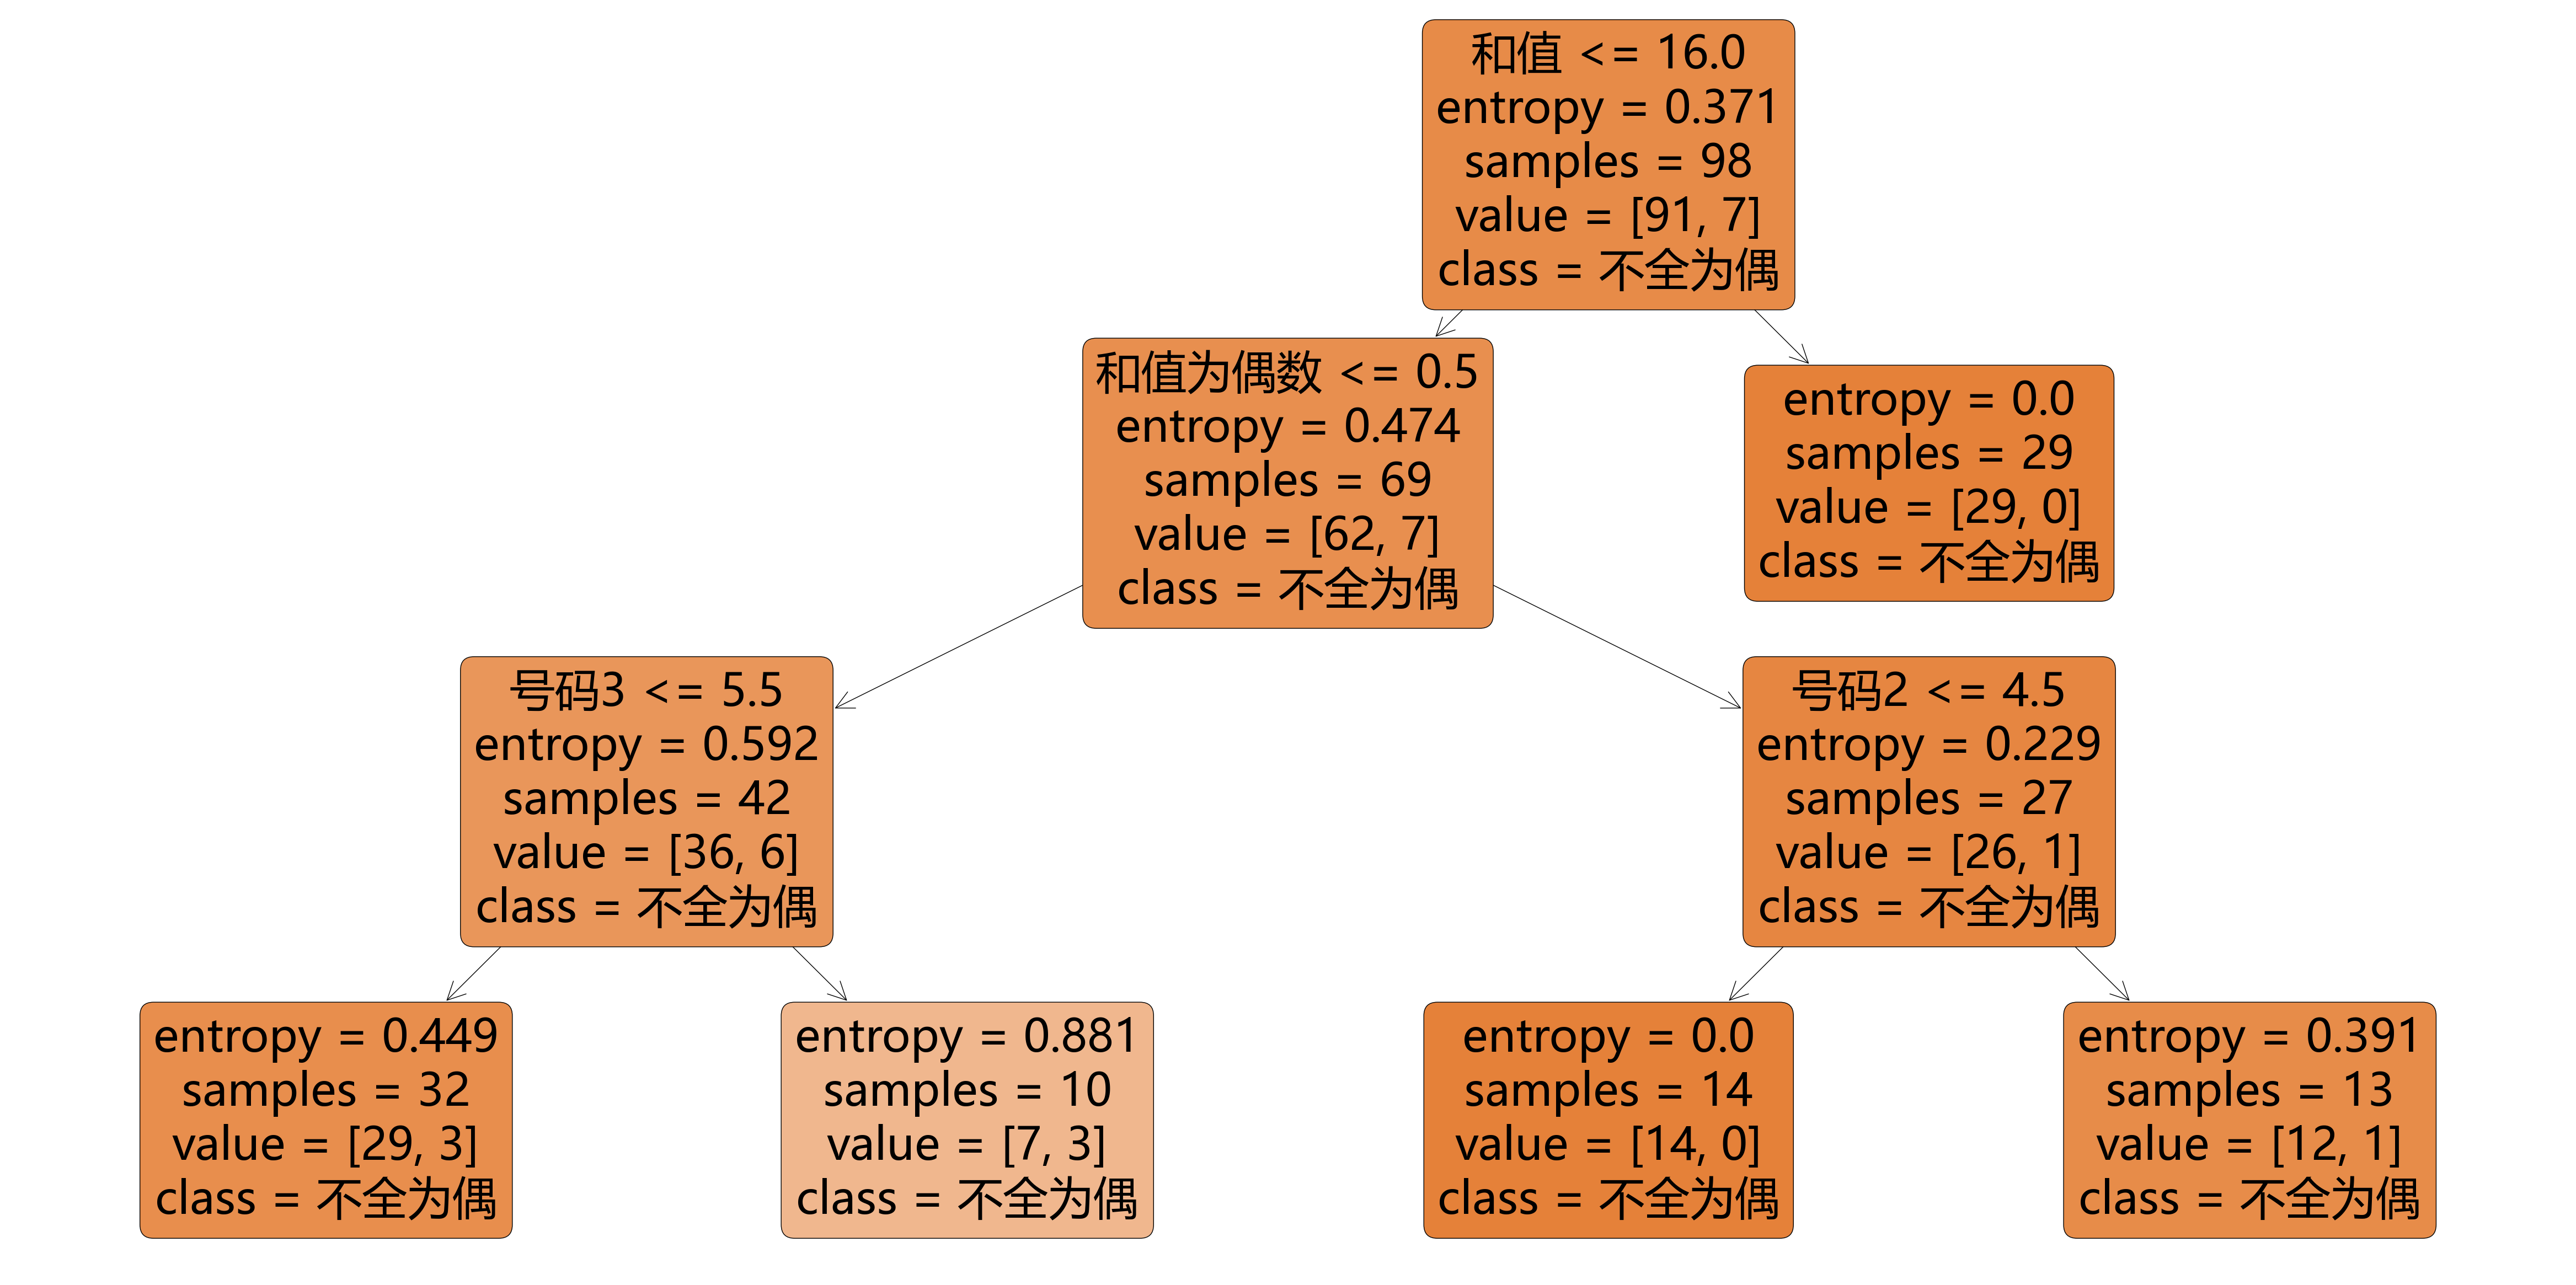

In [30]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import numpy as np

# 选择森林中的一棵树进行绘制
tree_num = 25   # 选择第n棵树
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 更好的中文字体，可以显示“-”号
plt.figure(figsize=(60,30))
print(clf.classes_)
plot_tree(clf.estimators_[tree_num], 
          feature_names=cols_x_names,
          class_names=COLS_Y_CLASSNAME, 
          filled=True, 
          rounded=True)
plt.show()

In [31]:
#返回指定要求的满足要求的期号
mask = (df['跨度'] < 4.5) & (df['号码3'] < 2.5) & (df['号码1'] > 2.5) 
# mask = (df['本期是否有6'] <=0.5 ) & (df['跨度为偶数'] >0.5) & (df['本期是否有4'] >0.5) 
# mask = (df['本期是否有6'] <=0.5 ) & (df['跨度为偶数'] >0.5) & (df['本期是否有4'] <=0.5) & (df['和值'] >14)
# mask = (df['和值为偶数'] > 0.5 ) & (df['跨度为偶数'] >0.5) & (df['跨度'] >5)
# mask = (df['跨度'] <= 0.5 )
print(df.loc[mask]['期号'])

34    2024236
43    2024227
68    2024202
80    2024190
Name: 期号, dtype: int64
